# Querying the Human Lung Cell Atlas

Here we demonstrate how to query the Human Lung Cell Atlas using scANVI, scArches, and scvi-hub.

- Sikkema, Lisa, et al. "An integrated cell atlas of the human lung in health and disease." [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (2022).

If you use this tutorial in your research we recommend citing the HLCA as well as scANVI, scArches, and scvi-tools, which can be found on the [references page](https://docs.scvi-tools.org/en/stable/references.html) at Gayoso22, Lotfollahi21, Xu21 respectively.

This tutorial is adapted from a [similar one](https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/notebooks/LCA_scArches_mapping_new_data_to_hlca.ipynb) presented by the HLCA authors.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [4]:
import numba
import numpy as np
import pandas as pd
import pynndescent
import scanpy as sc
import scvi
from scvi.hub import HubModel
from scvi.model.utils import mde

In [2]:
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Download the reference files

First we download the pre-trained scANVI model from the HuggingFace [repo](https://huggingface.co/scvi-tools/human-lung-cell-atlas).

In [5]:
hubmodel = HubModel.pull_from_huggingface_hub("scvi-tools/human-lung-cell-atlas")
adata = hubmodel.adata
model = hubmodel.model

/home/adam/Documents/software/scvi-tools/scvi/hub/hub_model.py:177: UserWarning: No revision was passed, so the default (latest) revision will be used.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

INFO     Reading adata...                                                                                          
INFO     Loading model...                                                                                          
INFO     File                                                                                                      
         /home/adam/.cache/huggingface/hub/models--scvi-tools--human-lung-cell-atlas/snapshots/7b770cb7cc26a307b933
         16de8a5f2ef47181937d/model.pt already downloaded                                                          
INFO     File                                                                                                      
         /home/adam/.cache/huggingface/hub/models--scvi-tools--human-lung-cell-atlas/snapshots/7b770cb7cc26a307b933
         16de8a5f2ef47181937d/model.pt already downloaded                                                          


/home/adam/Documents/software/scvi-tools/scvi/data/_utils.py:175: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/home/adam/Documents/software/scvi-tools/scvi/data/_utils.py:175: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [6]:
adata

AnnData object with n_obs × n_vars = 584884 × 2000
    obs: 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'sample', 'study', 'donor_id', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'size_factors', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy

In [8]:
model

ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: True

In [9]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0b1.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled',
│   'layer': None,
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   14   │
│         n_cells          │ 584884 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   29   │
│       n_latent_qzm       │   30   │
│       n_latent_qzv       │   30   │
│          n_vars          │  2000  │
└──────────────────────────┴────────┘

                        Data Registry                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │                adata.X                 │
│       batch       │        adata.obs['_scvi_batch']        │
│      labels       │       adata.obs['_scvi_labels']        │
│    latent_qzm     │    adata.obsm['_scanvi_latent_qzm']    │
│    latent_qzv     │    adata.obsm['_scanvi_latent_qzv']    │
│    minify_type    │  adata.uns['_scvi_adata_minify_type']  │
│ observed_lib_size │ adata.obs['_scanvi_observed_lib_size'] │
└───────────────────┴────────────────────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │   Banovich_Kropski_2020   │          0          │
│                      │     Barbry_Leroy_2020     │          1          │
│                      │ Jain_Misharin_2021_10Xv1  │          2          │
│                      │ Jain_Misharin_2021_10Xv2  │          3          │
│                      │       Krasnow_2020        │          4          │
│                      │ Lafyatis_Rojas_2019_10Xv1 │          5          │
│                      │ Lafyatis_Rojas_2019_10Xv2 │          6          │
│                      │        Meyer_2019         │          7          │
│                      │       Misharin_2021       │          8          │
│                      │  Misharin_Budinger_2018   │          9          │
│                      │        Nawijn_2021        │         10          │
│                      │    Seibold_2020_10Xv2     │         11          │
│                      │    Seibold_2020_10Xv3     │         12          │
│                      │   Teichmann_Meyer_2019    │         13          │
└──────────────────────┴───────────────────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scanvi_label'] │           AT1           │          0          │
│                           │           AT2           │          1          │
│                           │       Arterial EC       │          2          │
│                           │     B cell lineage      │          3          │
│                           │          Basal          │          4          │
│                           │   Bronchial Vessel 1    │          5          │
│                           │   Bronchial Vessel 2    │          6          │
│                           │        Capillary        │          7          │
│                           │        Ciliated         │          8          │
│                           │     Dendritic cells     │          9          │
│                           │   Fibroblast lineage    │         10          │
│                           │ KRT5- KRT17+ epithelial │         11          │
│                           │      Lymphatic EC       │         12          │
│                           │       Macrophages       │         13          │
│                           │       Mast cells        │         14          │
│                           │     Megakaryocytes      │         15          │
│                           │       Mesothelium       │         16          │
│                           │        Monocytes        │         17          │
│                           │      Neutrophilic       │         18          │
│                           │      Non-T/B cells      │         19          │
│                           │   Proliferating cells   │         20          │
│                           │          Rare           │         21          │
│                           │        Secretory        │         22          │
│                           │      Smooth Muscle      │         23          │
│                           │        Squamous         │         24          │
│                           │  Submucosal Secretory   │         25          │
│                           │     T cell lineage      │         26          │
│                           │         Venous          │         27          │
│                           │        unlabeled        │         28          │
└───────────────────────────┴─────────────────────────┴─────────────────────┘

## Learn a neighbors index on reference latent space

Here we create the neighbors index using `PyNNDescent`. We will use this later to classify query cells. `PyNNDescent` is an extremely fast approximate neighbors technique.

In the case of the `HubModel` instance above, we see that the data is in minified mode, meaning the count data is not actually in the object, and we only store a minified representation of the data. We see that we can access the mean of the embedding (`latent_qzm`) above.

In [7]:
X_train = adata.obsm["_scanvi_latent_qzm"]
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

## Download query data

In this tutorial we use the fresh, single-cell sample from the following publication:

- Delorey, Toni M., et al. "COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets." Nature 595.7865 (2021): 107-113.

In principle at this stage you may load your own data. There are few important notes though:

- Using the HLCA requires using Gene IDs for the query data
- The query data should include batches in `query_data.obs["dataset"]`
- It's necessary to run `query_data.obs["scanvi_label"] = "unlabeled"` so that scvi-tools can properly register the query data.

In [10]:
%%capture
%%bash
wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz -O data/query_test.h5.gz
gzip -d data/query_test.h5.gz

In [37]:
geo_metadata_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz"
metadata = pd.read_csv(geo_metadata_url, index_col=0)
query_data = sc.read_10x_h5("data/query_test.h5")
# clean up .var.index (gene names)
query_data.var["gene_names"] = query_data.var.index
query_data.var.index = [idx.split("___")[-1] for idx in query_data.var.gene_ids]
# clean up cell barcodes:
query_data.obs.index = query_data.obs.index.str.rstrip("-1")
# read in metadata (to select only cells of interest and remove empty drops)
# subset to cells from our sample
metadata = metadata.loc[metadata.donor == "D12_4", :].copy()
# clean up barcodes:
metadata.index = [idx.split("-")[-1] for idx in metadata.index]
# subset adata to cells in metadata:
query_data = query_data[metadata.index, :].copy()
# add dataset information:
query_data.obs["dataset"] = "test_dataset_delorey_regev"

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Loading the query model from the reference files

Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness.

<div class="alert alert-info">
Important

Below we use the path to the model we downloaded from HuggingFace. While in most cases the model instance can be used instead of the path, here the reference model's adata is in minified mode.

</div>

In [38]:
scvi.model.SCANVI.prepare_query_anndata(query_data, model)

INFO     Found 99.65% reference vars in query data.                                                                


/home/adam/Documents/software/scvi-tools/scvi/model/base/_archesmixin.py:212: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


From above, we see that the model is expecting a labels key with the name `"scanvi_label"`.

In [41]:
query_data.obs["scanvi_label"] = "unlabeled"

In [42]:
query_model = scvi.model.SCANVI.load_query_data(query_data, model)

Here we use scArches/scANVI-specific query training arguments.

In [43]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [44]:
query_model.train(max_epochs=surgery_epochs, **train_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 201/500:  40%|████      | 201/500 [00:27<00:41,  7.20it/s, loss=477, v_num=1]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 527.757. Signaling Trainer to stop.


In [45]:
query_save_path = "data/hcla_query/"
query_model.save(query_save_path, overwrite=True)

In [46]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

Now let's store the predictions in the query embedding object. We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities.

This follows the same approach used in the HLCA.

In [47]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty


# for each annotation level, get prediction and uncertainty
label_keys = [f"ann_level_{i}" for i in range(1, 6)] + ["ann_finest_level"]
for l in label_keys:
    ref_cats = adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

Now let's filter our predictions on the uncertainty threshold, which is discussed in the HLCA manuscript.

In [48]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

ann_level_1: 0.0033594624860022394 unknown
ann_level_2: 0.007278835386338186 unknown
ann_level_3: 0.07390817469204927 unknown
ann_level_4: 0.3891377379619261 unknown
ann_level_5: 0.007838745800671893 unknown
ann_finest_level: 0.4087346024636058 unknown


/tmp/ipykernel_118249/642663619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"


In [49]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"

## Combine embeddings

In [50]:
ref_emb = sc.AnnData(X_train, obs=adata.obs)
ref_emb

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'sample', 'study', 'donor_id', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'size_factors', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_s

In [51]:
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty', 'dataset'

In [52]:
combined_emb = ref_emb.concatenate(query_emb)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


## Visualize embeddings and predictions

To visualize here we use [minimum distortion embeddings](https://pymde.org/), which for now can be thought of as an alternative of UMAP that is GPU-accelerated (= really fast on Colab). While we use `init="random"` here, we recommend removing this argument in practice and only leave it here to make the notebook run faster.

In [53]:
combined_emb.obsm["X_mde"] = mde(combined_emb.X, init="random")

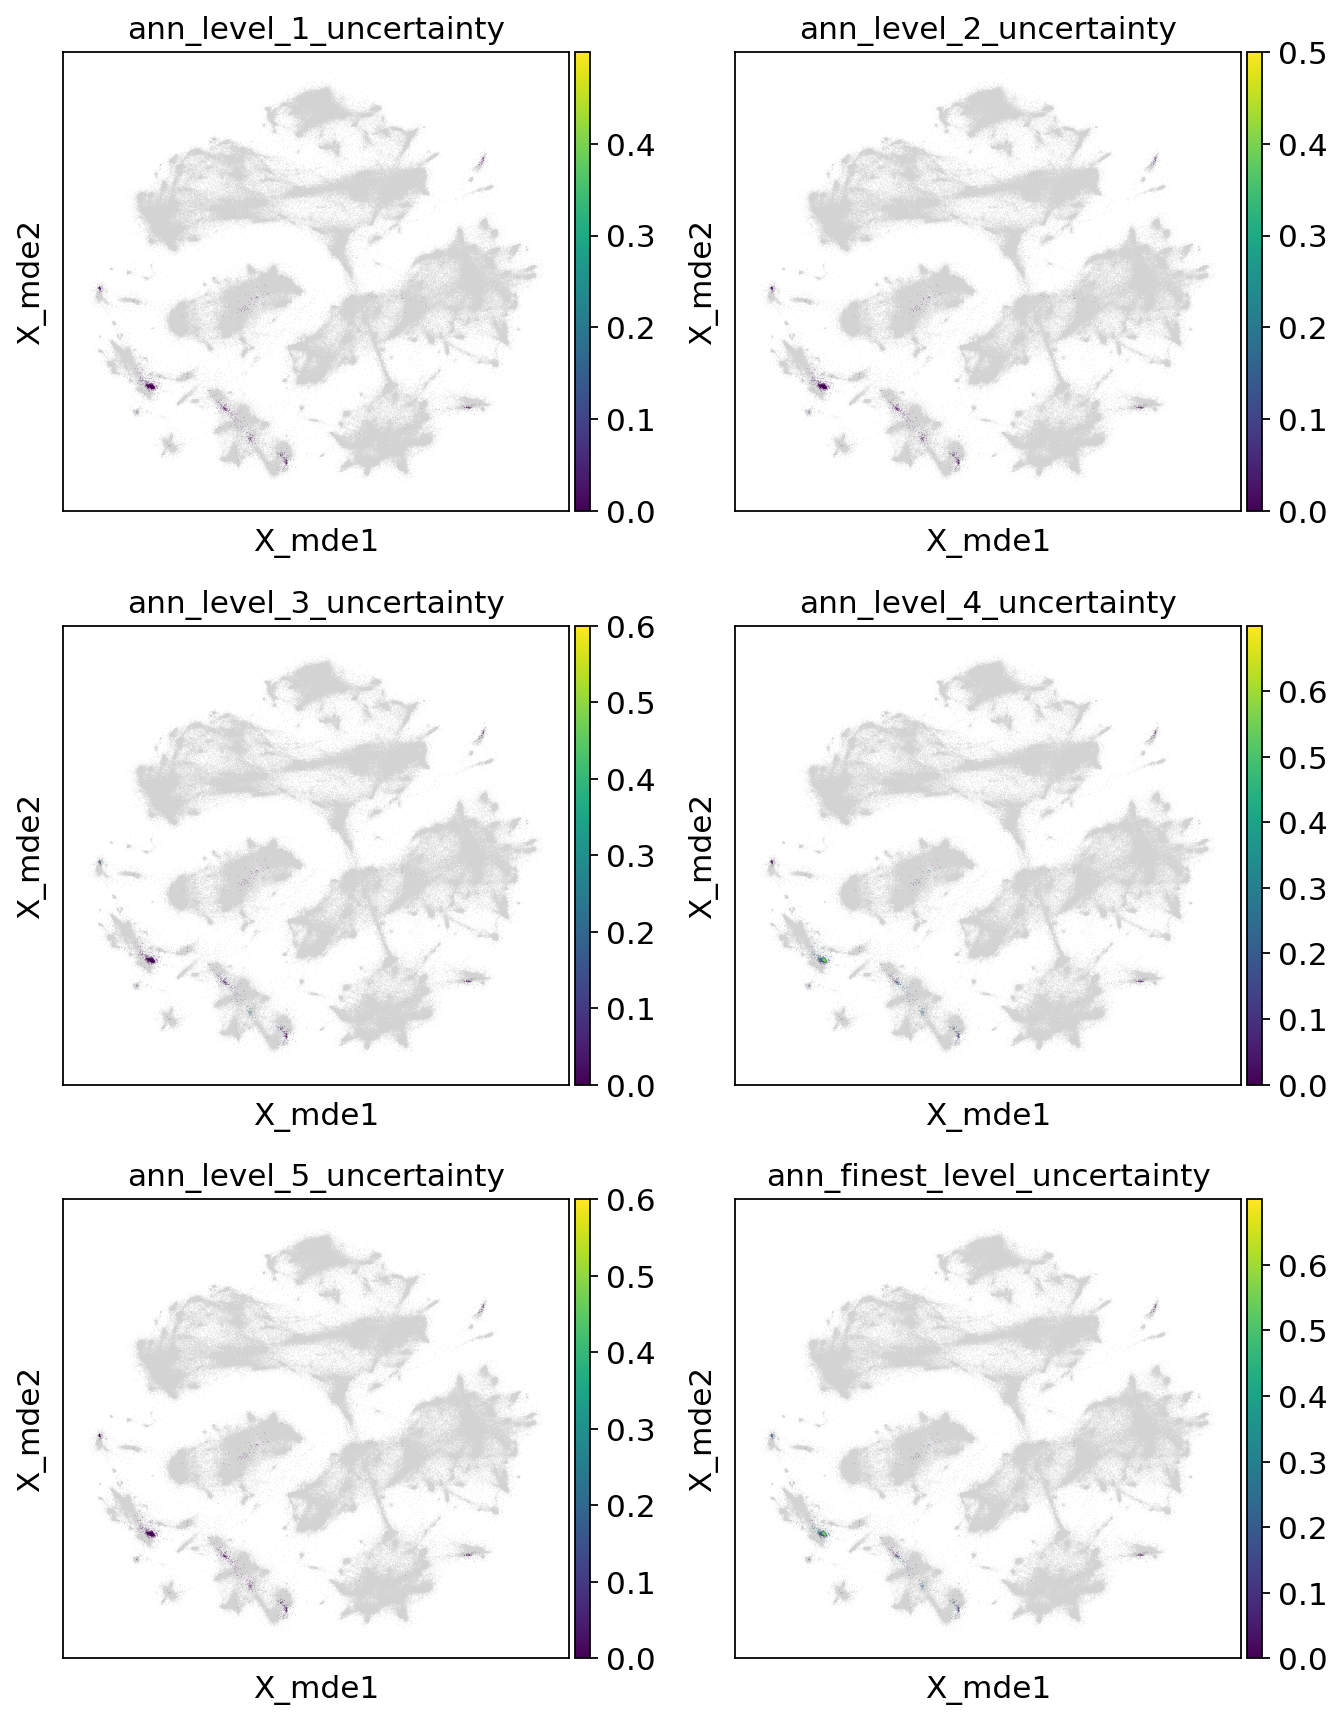

In [54]:
colors = [l + "_uncertainty" for l in label_keys]
sc.pl.embedding(
    combined_emb,
    basis="X_mde",
    color=colors,
    ncols=2,
)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:39

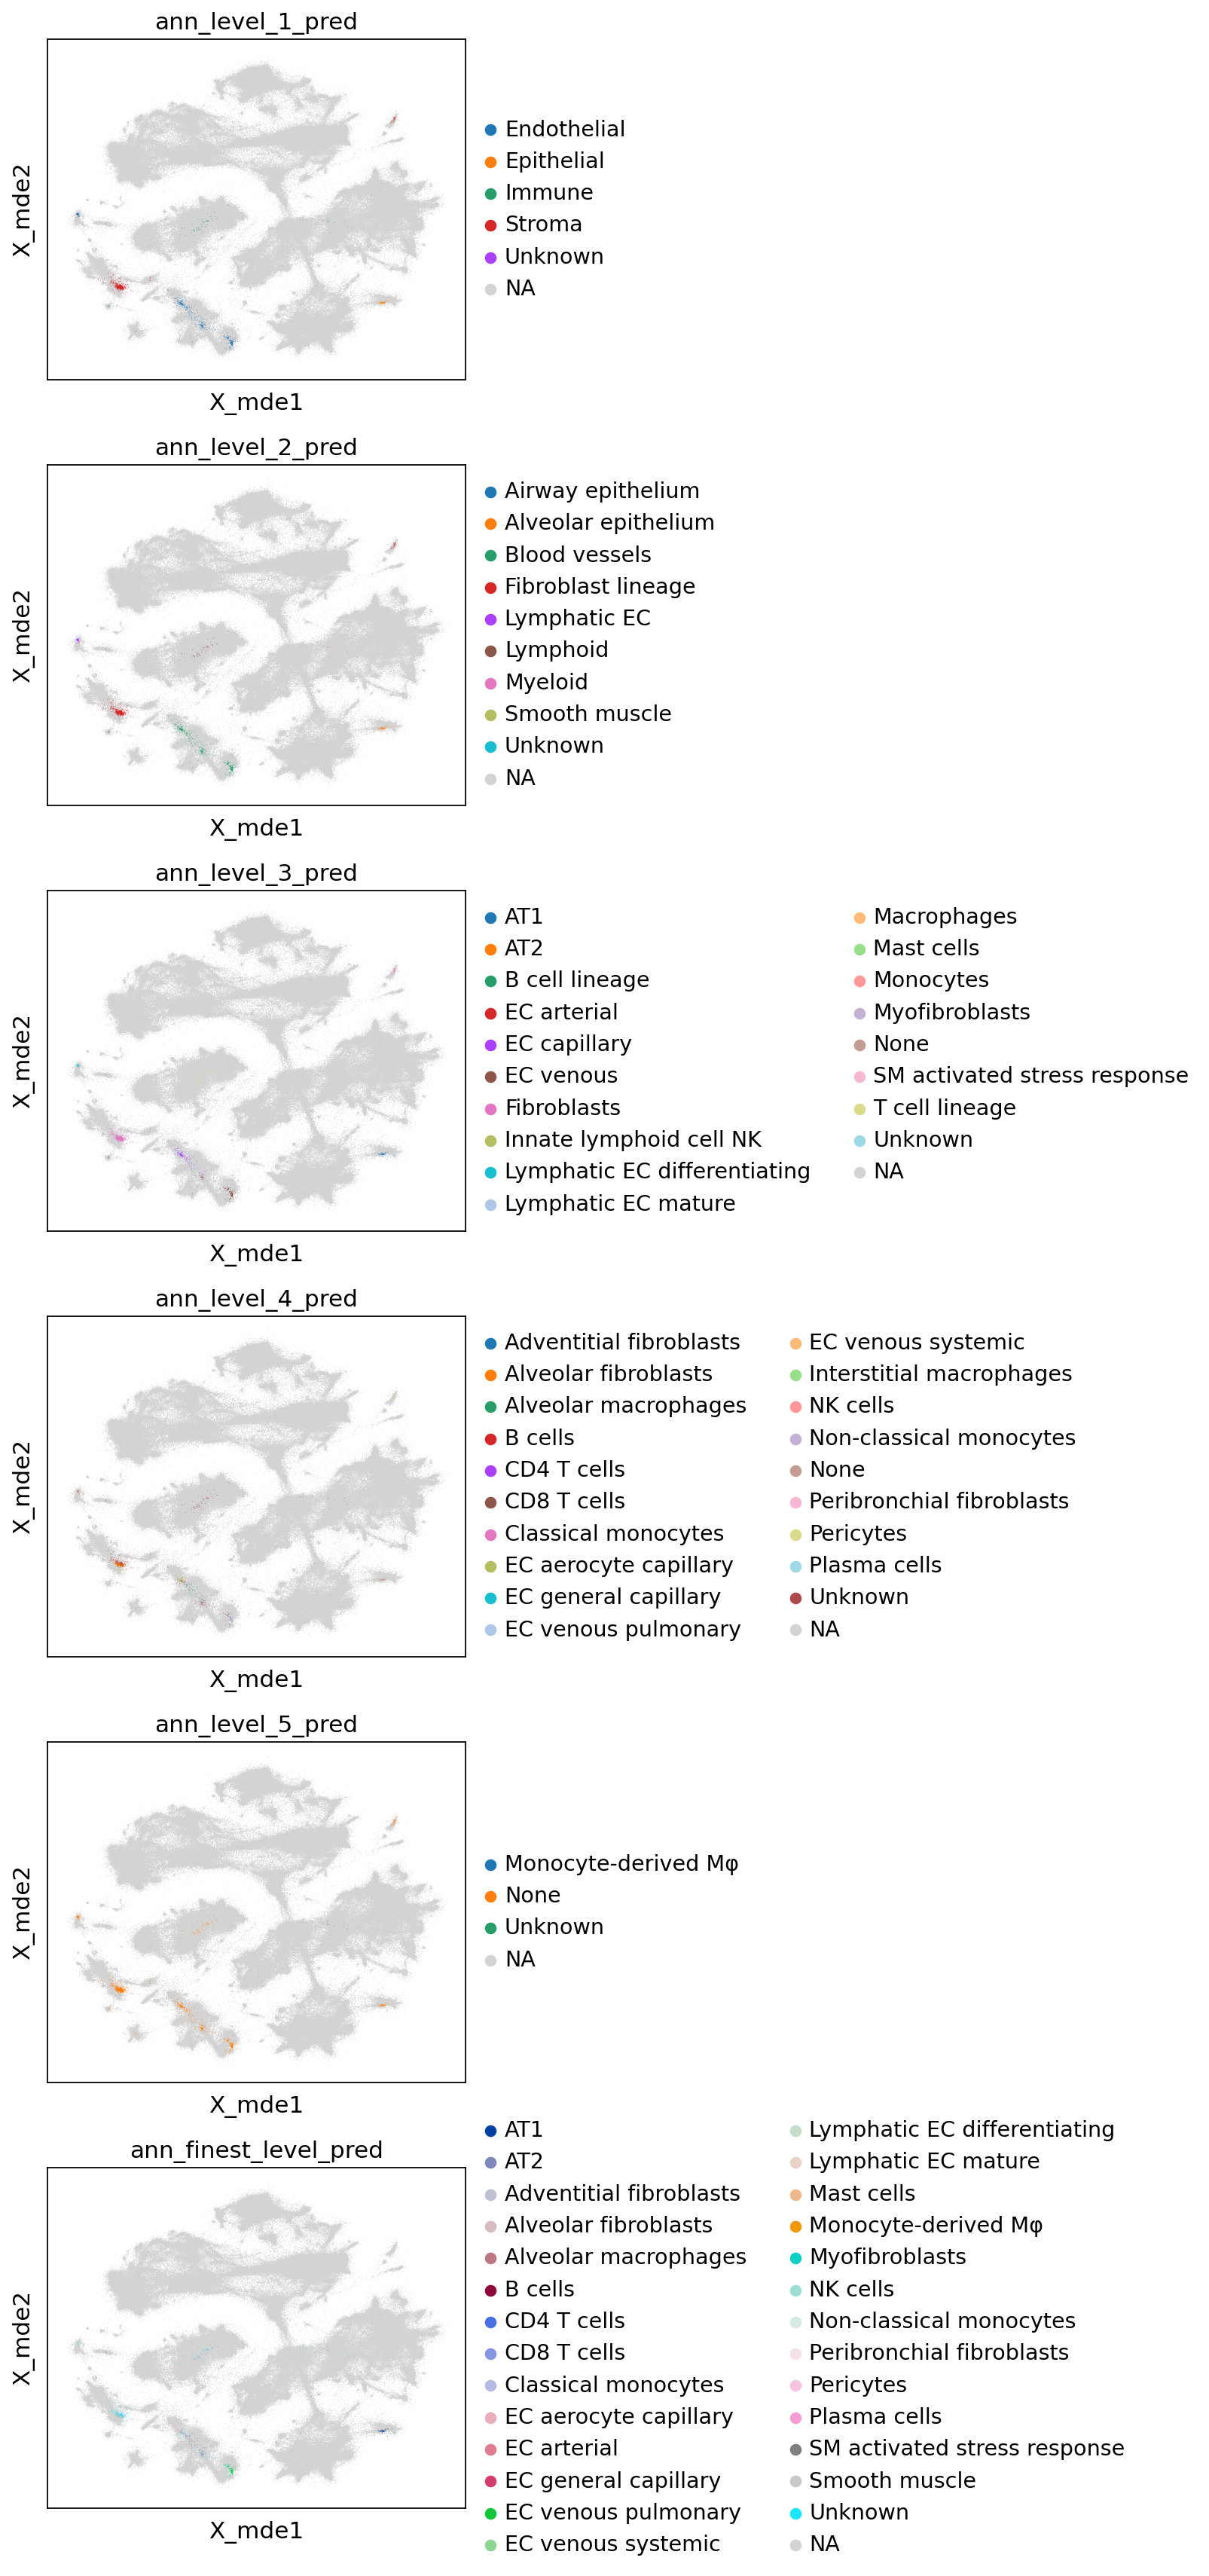

In [55]:
colors = [l + "_pred" for l in label_keys]

sc.pl.embedding(combined_emb, basis="X_mde", color=colors, ncols=1, size=0.5)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


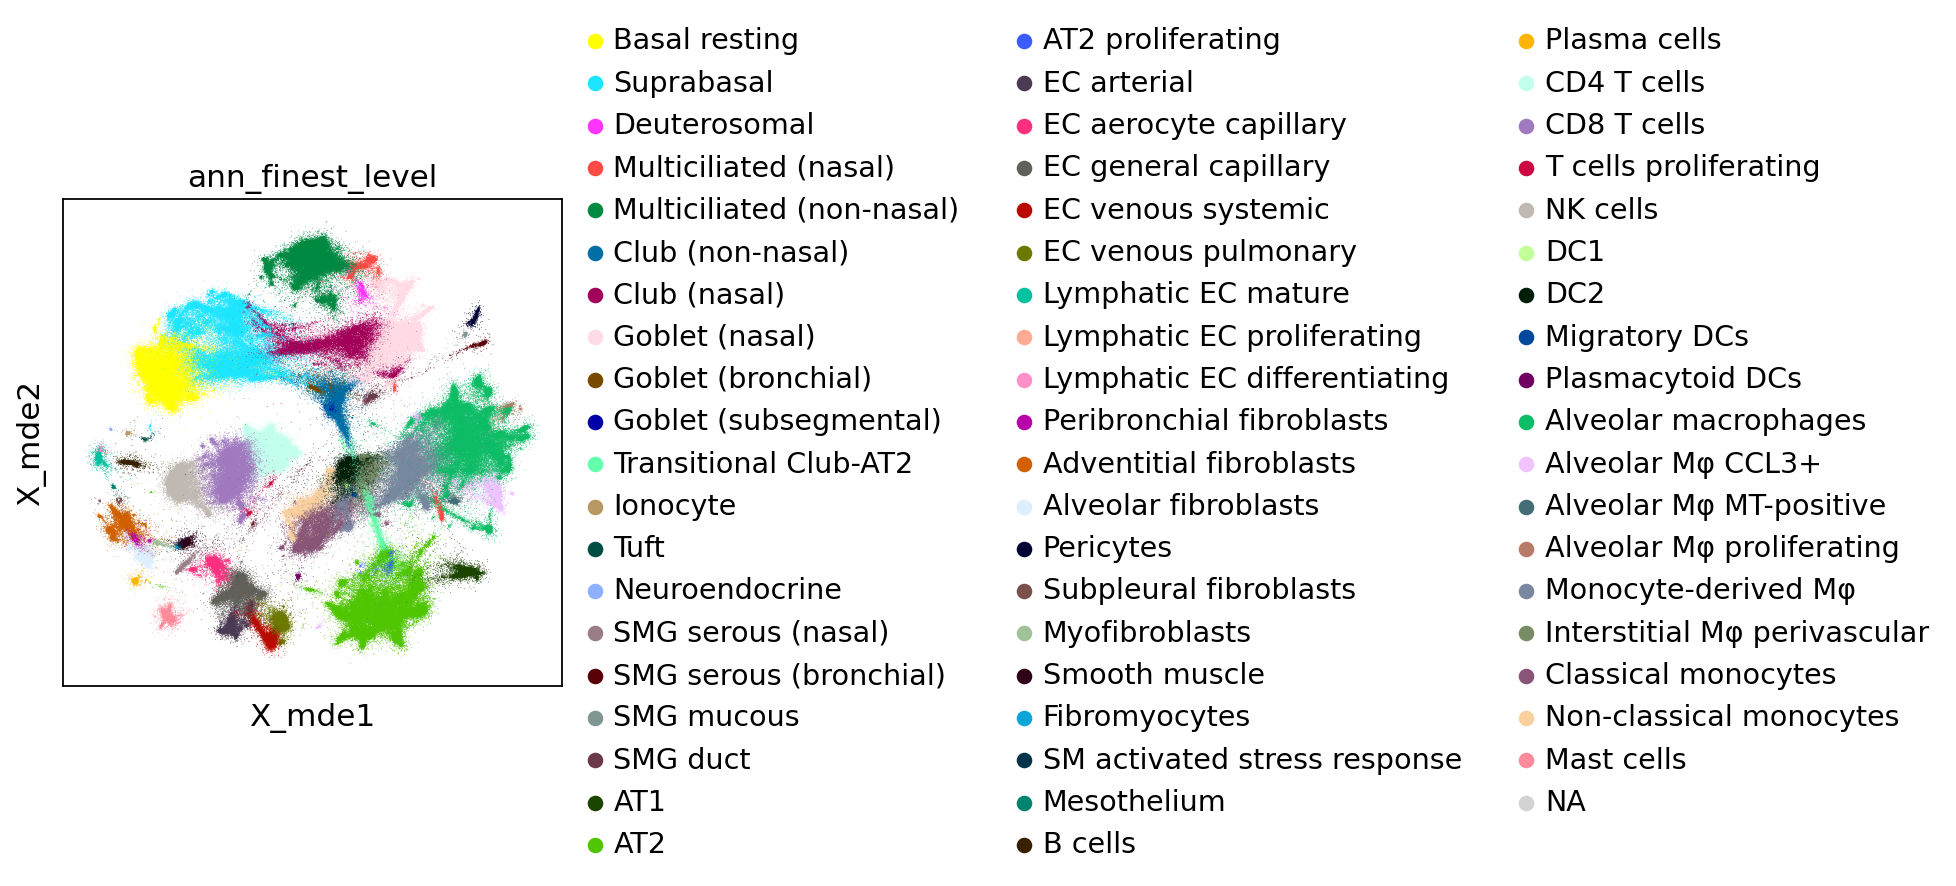

In [56]:
sc.pl.embedding(
    combined_emb, basis="X_mde", color="ann_finest_level", ncols=1, size=0.5
)